# Signal Similarity

We want to use the FFT and filtering to decide which signals are more similar to each other and which are more different.

This can be crutial to then do things like: clustering, classificaiton, pattern recognition.

# Distances between signals
Consider a collection of weather measurements that come from different locations on a map
\begin{align}
X_i(t) = s_i(t) + \eta_i(t)
\end{align}

We want to say which cities have more similar long term weather trends.  In other words, how far apart are
\begin{align}
d(X_i(t), X_j(t)) = ?
\end{align}

We imagine there are two worlds, Earth and Tataouine.  Earth has one sun so it shows up once a day, and Tataouine has two suns.  Tataouine rotates around one, but the other spins around the planet at a faster rate.  Each world has two cities, and we want to use temparature measurements to determine which cities are on the same world.

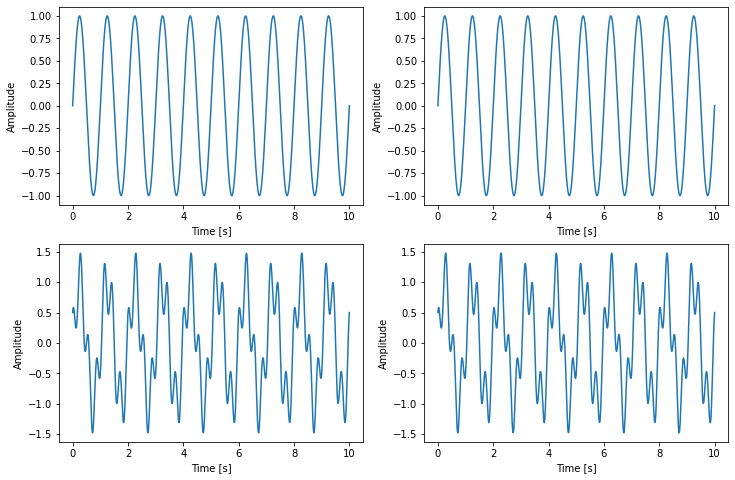

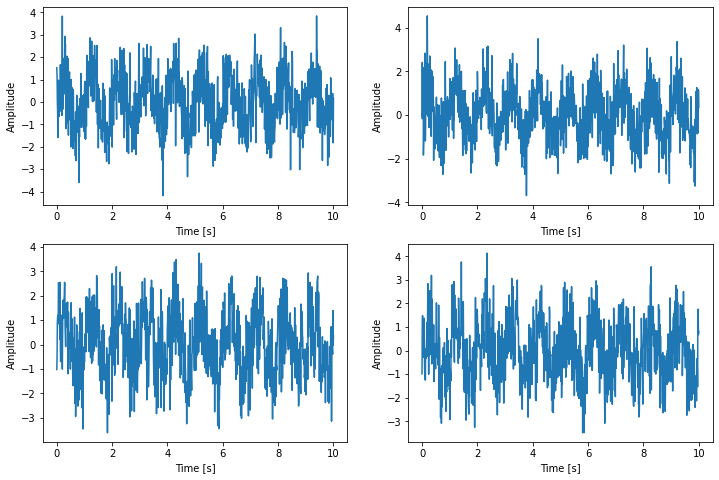

In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt 

# Create signal
N = 1000
t = np.linspace(0, 10, N)
f = []
s = []
for k in range(2):
    stmp = np.sin(2*np.pi * t)

    s.append(stmp)
    
    n = np.random.randn(N)

    f.append(stmp + n)
    
    
for k in range(2):
    stmp = np.sin(2*np.pi * t) + 0.5 * np.cos(7*np.pi * t)#*np.sin(3*t)
    
    s.append(stmp)

    n = np.random.randn(N)

    f.append(stmp + n)
    
plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.plot(t, s[k])
    
plt.show()

plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.plot(t, f[k])


plt.show()



## What if we just compute Euclidean distance between these signals?

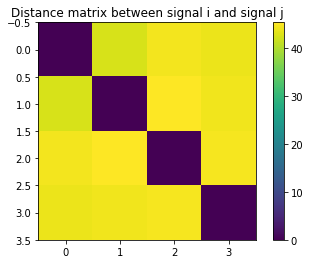

In [3]:
# All pairwise Euclidean distances
D = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        D[i,j] = np.linalg.norm(f[i] - f[j])
    
    
fig, ax = plt.subplots()
plt.title("Distance matrix between signal i and signal j")
im = ax.imshow(D)
fig.colorbar(im, ax=ax)
plt.show()

## What if we did the same thing in DFT space?

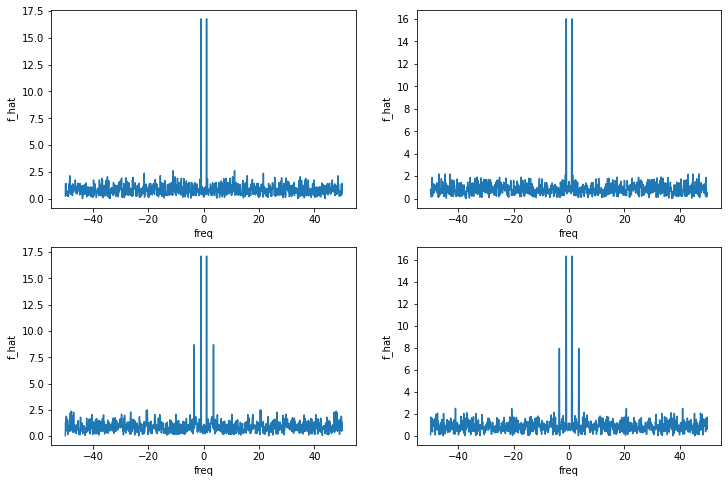

In [4]:
# Compute all DFTs
f_hat = []
for k in range(4):
    f_hat.append(np.fft.fft(f[k], norm='ortho'))
    
T = t[1] - t[0]  # sampling interval 
fs_shifted = np.linspace(-1/(2*T), 1/(2*T), N)

plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("f_hat")
    plt.xlabel("freq")
    plt.plot(fs_shifted,np.abs(np.fft.fftshift(f_hat[k])))

plt.show()


## Clearly they look different in DFT space, so hopefully distances will be better

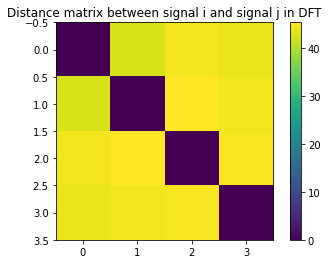

In [5]:
# All pairwise Fourier distances.  We multiply by sqrt(N) so that DFT is an ONB transformation
D_hat = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        D_hat[i,j] =  np.linalg.norm(f_hat[i] - f_hat[j])
      
fig, ax = plt.subplots()
plt.title("Distance matrix between signal i and signal j in DFT")
im = ax.imshow(D_hat)
fig.colorbar(im, ax=ax)
plt.show()

## They're the exact same!  Why?!?

Maybe this has something to do with Parseval's identity!  Recall:
\begin{align}
\|x\|^2 = \sum_k |\widehat{x}[k]|^2 = \|\widehat{x}\|^2
\end{align}

So if you compute distances, you get
\begin{align}
\|f_i - f_j\|^2 = \|\widehat{f}_i - \widehat{f}_j\|^2
\end{align}

\begin{align}
\|f_i - f_j\|^2 = \|\widehat{f_i - f_j}\|^2
\end{align}

They're the same!  So maybe we need to change our definition of distance

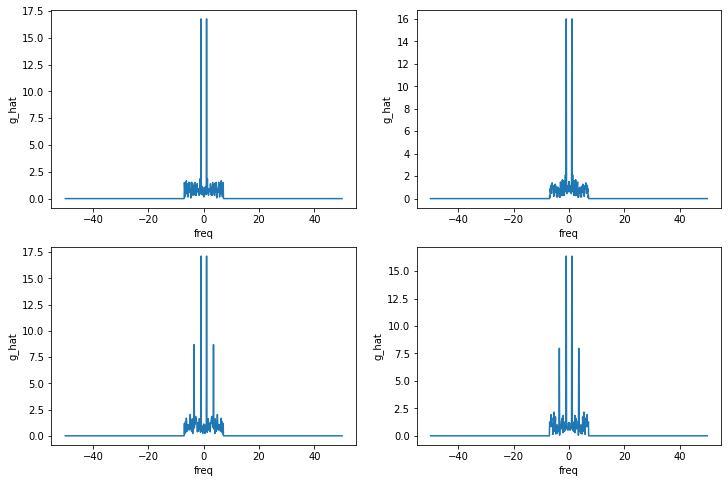

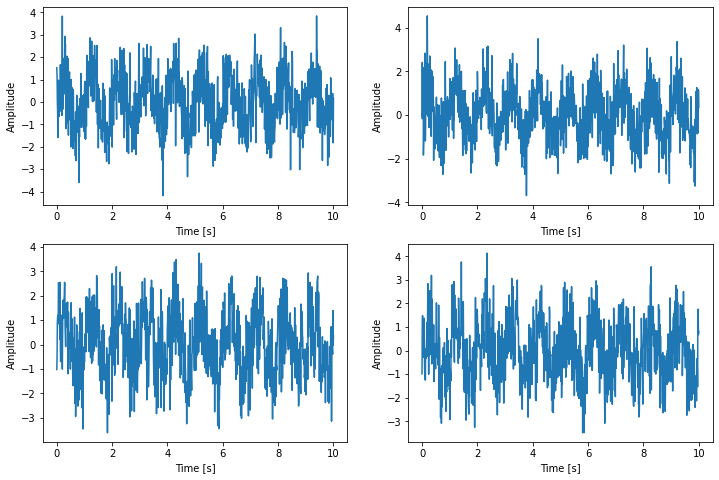

In [6]:
# Filter all signals with rectangular low-pass filter
#  Largest oscillation is 7 times a day for 10 days, so largest k of 70
k_0 = 70

h_hat = np.ones(N)
h_hat[k_0+1 : N-k_0] = 0

g_hat = []
for k in range(4):
    g_hat.append(f_hat[k]*h_hat)

plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("g_hat")
    plt.xlabel("freq")
    plt.plot(fs_shifted, np.abs(np.fft.fftshift(g_hat[k])))

plt.show()


g = []
for k in range(4):
    g.append(np.fft.ifft(g_hat[k], norm='ortho'))
    
plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.plot(t, f[k])


plt.show()



## So let's define distances on this new filtered g

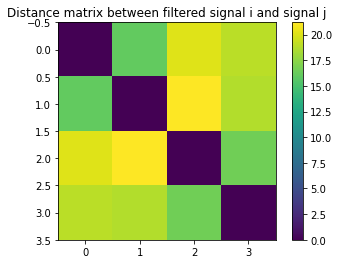

In [9]:
# All pairwise filtered Fourier distances
D_filter = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        D_filter[i,j] = np.linalg.norm(g[i] - g[j])
      
fig, ax = plt.subplots()
plt.title("Distance matrix between filtered signal i and signal j")
im = ax.imshow(D_filter)
fig.colorbar(im, ax=ax)
plt.show()

## Way better!!!!  
What if instead we were able to find these large peaks of the signal only

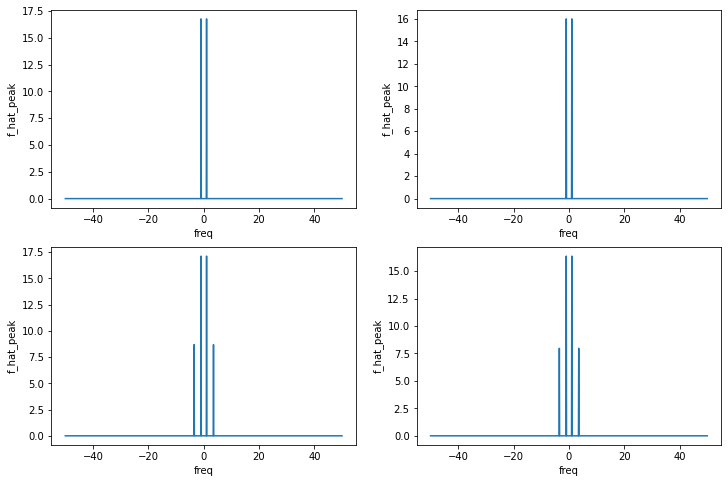

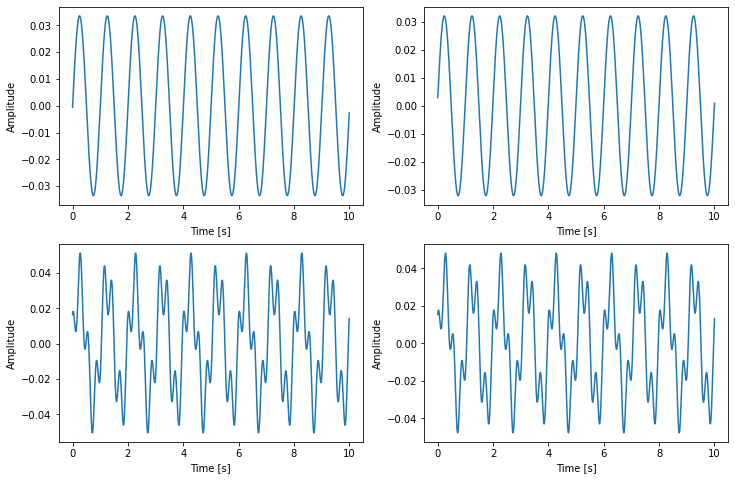

In [10]:
# Set a peak threshold
height = 5

f_hat_peak = []
for k in range(4):
    f_hat_tmp = f_hat[k]
    f_hat_tmp[np.abs(f_hat_tmp)<height] = 0
    f_hat_peak.append(f_hat_tmp)

plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("f_hat_peak")
    plt.xlabel("freq")
    plt.plot(fs_shifted, np.abs(np.fft.fftshift(f_hat_peak[k])))

plt.show()


f_peak = []
for k in range(4):
    f_peak.append(np.real(np.fft.ifft(f_hat_peak[k])))

plt.figure(figsize=(12,8))    
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.plot(t, f_peak[k])


plt.show()

## Those look exactly like the original signals!
Let's define distances now

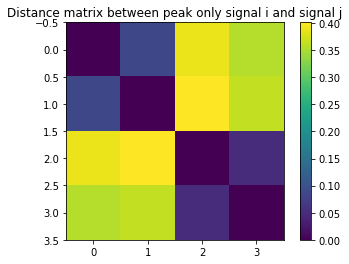

In [12]:
# All pairwise peak only Fourier distances
D_peak = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        D_peak[i,j] = np.linalg.norm(f_peak[i] - f_peak[j])
      
fig, ax = plt.subplots()
plt.title("Distance matrix between peak only signal i and signal j")
im = ax.imshow(D_peak)
fig.colorbar(im, ax=ax)
plt.show()

# Got it perfectly!!!  We now know which cities are on Earth and which are on Tataouine.  And it was all about figuring out which frequencies we needed to keep around.
# Each time we redefined a distance between signals.  And all (other than the first) were non-Euclidean distances

# What if we are worried about shifted signals?
We get a collection of signals from accelarometers that are attached to either:
- someone doing jumping jacks (rapid accelerations)
- someone doing deadlifts (slow accelerations)

However, we don't get to see when they start/stop.  Just know that at some point during recording they did a set.  Can we classify?

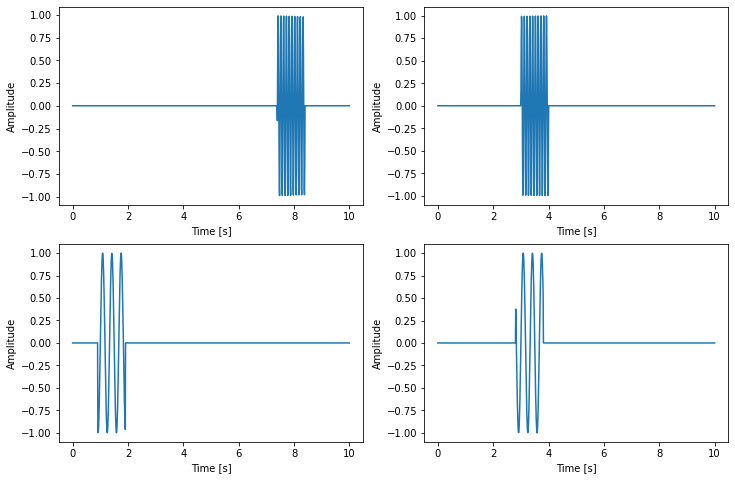

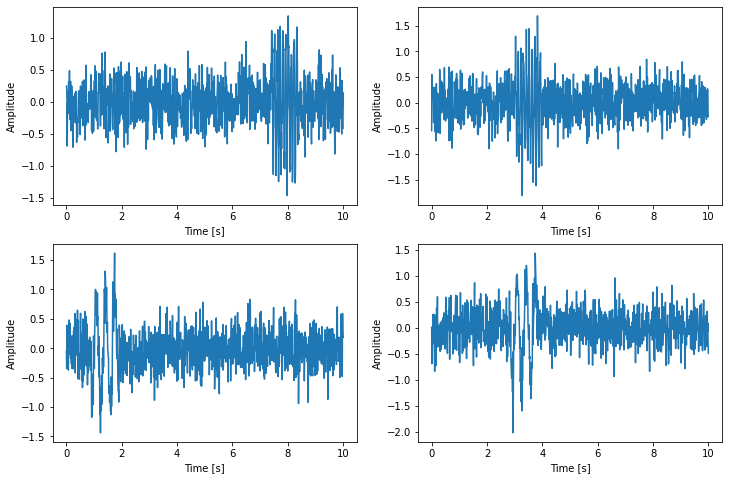

In [13]:
# Packages
import numpy as np
import matplotlib.pyplot as plt 

# Create signal
N = 1000
t = np.linspace(0, 10, N)
f = []
s = []
for k in range(2):
    
    t_0 = np.random.randint(0,9*N//10)
    stmp = np.zeros(N)
    stmp[t_0: (t_0 + N//10)] = np.sin(2*10*np.pi * t[t_0: (t_0 + N//10)])

    s.append(stmp)
    
    n = .3*np.random.randn(N)

    f.append(stmp + n)
    
    
for k in range(2):
    t_0 = np.random.randint(0,9*N//10)
    stmp = np.zeros(N)
    stmp[t_0: (t_0 + N//10)] = np.sin(2*3*np.pi * t[t_0: (t_0 + N//10)])
    
    s.append(stmp)

    n = .3*np.random.randn(N)

    f.append(stmp + n)
    
plt.figure(figsize=(12,8))    
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.plot(t, s[k])
    
plt.show()

plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.plot(t, f[k])


plt.show()



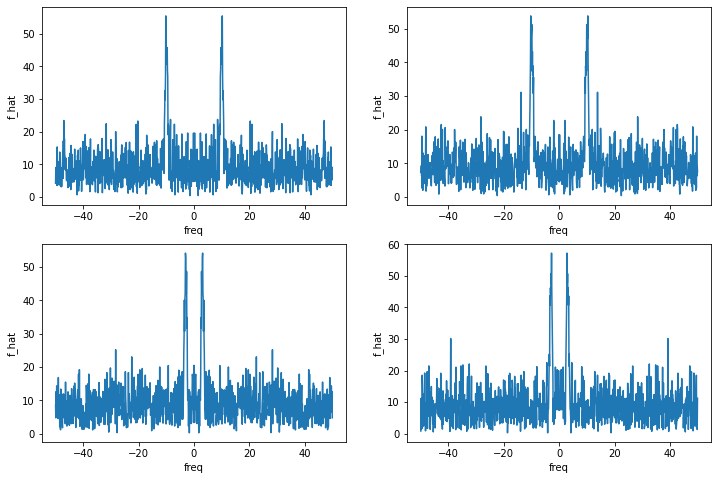

In [14]:
# Compute all DFTs
f_hat = []
for k in range(4):
    f_hat.append(np.fft.fft(f[k]))
    
T = t[1] - t[0]  # sampling interval 
fs_shifted = np.linspace(-1/(2*T), 1/(2*T), N)

plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("f_hat")
    plt.xlabel("freq")
    plt.plot(fs_shifted,np.abs(np.fft.fftshift(f_hat[k])))

plt.show()


## Let's look a Euclidean Distances

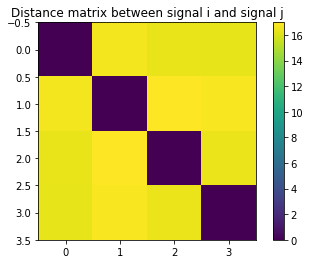

In [15]:
# All pairwise Euclidean distances
D = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        D[i,j] = np.linalg.norm(f[i] - f[j])
      
fig, ax = plt.subplots()
plt.title("Distance matrix between signal i and signal j")
im = ax.imshow(D)
fig.colorbar(im, ax=ax)
plt.show()

## These don't capture distances well at all because nonzero parts are moved around
We could filter but that may not help.  

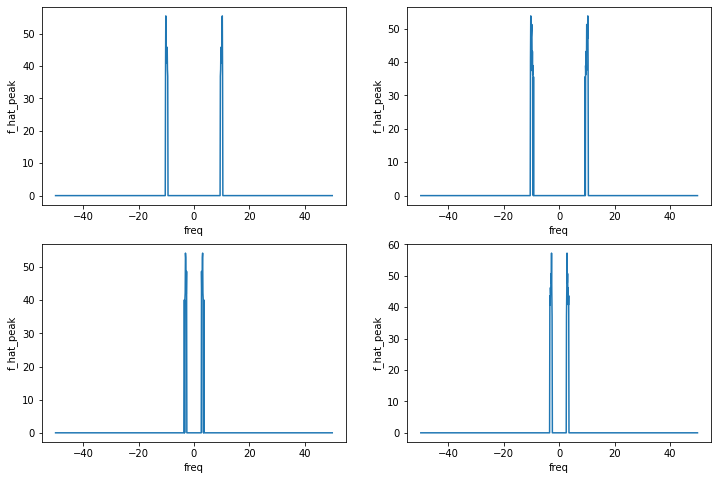

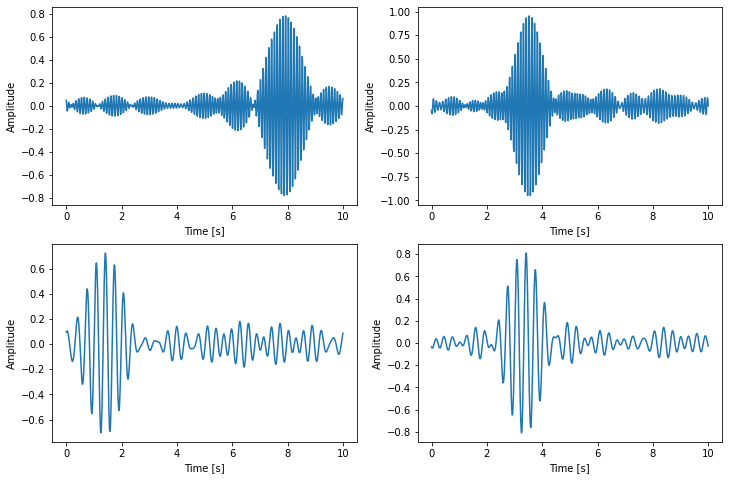

In [17]:
# Set a peak threshold
height = 35

f_hat_peak = []
for k in range(4):
    f_hat_tmp = f_hat[k]
    f_hat_tmp[np.abs(f_hat_tmp)<height] = 0
    f_hat_peak.append(f_hat_tmp)

plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("f_hat_peak")
    plt.xlabel("freq")
    plt.plot(fs_shifted, np.abs(np.fft.fftshift(f_hat_peak[k])))

plt.show()
     
f_peak = []            
for k in range(4):
    f_peak.append(np.real(np.fft.ifft(f_hat_peak[k])))


plt.figure(figsize=(12,8))             
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.plot(t, f_peak[k])


plt.show()

      


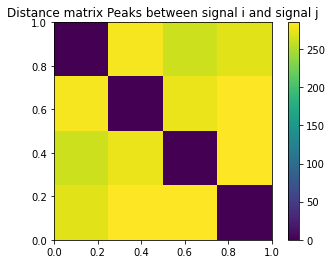

In [18]:
# All pairwise Peak Value distances in Fourier space
D_peak = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        D_peak[i,j] = np.linalg.norm(f_hat_peak[i] - f_hat_peak[j])
      
fig, ax = plt.subplots()
plt.title("Distance matrix Peaks between signal i and signal j")
im = ax.imshow(D_peak, extent=[0, 1, 0, 1])
fig.colorbar(im, ax=ax)
plt.show()

## Still didn't work!
But recall, problem is time shifts.  We know that
\begin{align}
y[n] &= x[n-n_0]\\
\widehat{y}[k] &= \overline{\omega}_N^{kn_0} \widehat{x}[k]
\end{align}

So even when you want to measure distances, the phase is messing you up!

But what if instead we work with $|\widehat{y}[k]|$.  Then 
\begin{align}
|\widehat{y}[k]| = |\widehat{x}[k]|,
\end{align}
which is exactly what we want!

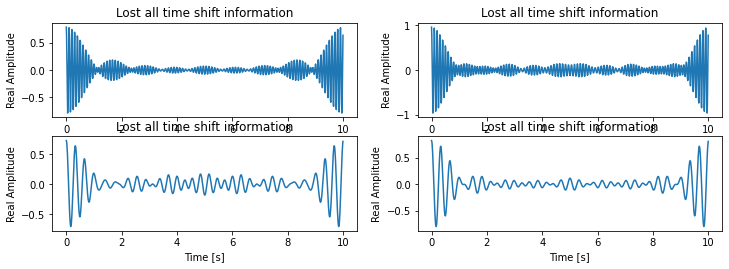

1.3012937947704517e-16


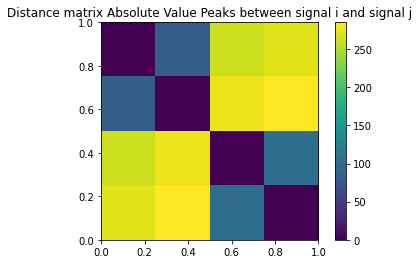

In [19]:
f_hat_abs = []            
for k in range(4):
    f_hat_abs.append(np.abs(f_hat_peak[k]))  # Absolute value to eliminate time shift issues
    

f_abs = []            
for k in range(4):
    f_abs.append(np.fft.ifft(f_hat_abs[k]))
       
plt.figure(figsize=(12,8))
for k in range(4):
    plt.subplot(4, 2, k+1)
    plt.title("Lost all time shift information")        
    plt.ylabel("Real Amplitude")
    plt.xlabel("Time [s]")
    plt.plot(t, np.real(f_abs[k]))


plt.show()

# Imaginary part of signal still small because Fourier part on either side of N/2 is complex conjugate of other
imaginary_part = np.linalg.norm(np.imag(f_abs[0]))/np.linalg.norm(f_abs[0])
print(imaginary_part)
             



# All pairwise Peak Value distances in Fourier space
D_abs = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        D_abs[i,j] = np.linalg.norm(f_hat_abs[i] - f_hat_abs[j])
      
fig, ax = plt.subplots()
plt.title("Distance matrix Absolute Value Peaks between signal i and signal j")
im = ax.imshow(D_abs, extent=[0, 1, 0, 1])
fig.colorbar(im, ax=ax)
plt.show()